## Importar Bibliotecas

In [222]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

### Funções Auxiliares

In [235]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Função ajustada para projeção local com tratamento escalonado e efeitos dinâmicos/heterogêneos
def local_projection_did(data, y, treat_col, time_col, id_col, covariates=None, horizon=1):
    """
    Estima o efeito de tratamento usando projeção local (Local Projection) com Diferenças-em-Diferenças,
    lidando com adoção escalonada e efeitos dinâmicos/heterogêneos.

    Args:
    - data: DataFrame contendo os dados.
    - y: Nome da variável de resposta.
    - treat_col: Nome da coluna de tratamento (indicador de tratamento).
    - time_col: Nome da coluna de tempo.
    - id_col: Nome da coluna de identificação das unidades.
    - covariates: Lista de nomes das covariáveis, se houver.
    - horizon: Horizonte de tempo após o tratamento para ser considerado (1 por padrão).

    Returns:
    - result: OLS regression result object, or None if insufficient data.
    """
    # Ordenar os dados pelas unidades e tempo
    data = data.sort_values(by=[id_col, time_col])

    # Detectar o momento do primeiro tratamento para cada unidade (tratamento escalonado)
    data['treatment_start'] = data.groupby(id_col)[treat_col].transform(
        lambda x: (x == 1).idxmax() if x.max() == 1 else np.nan
    )

    # Calcular o horizonte de tempo após o tratamento
    data['horizon'] = data[time_col] - data['treatment_start']

    # Considerar apenas observações pós-tratamento com horizonte >= 0
    post_treatment_data = data[data['horizon'] >= horizon]

    # Remover unidades que nunca receberam tratamento
    post_treatment_data = post_treatment_data.dropna(subset=['treatment_start'])

    # Garantir que há observações suficientes pós-tratamento
    if post_treatment_data.empty or post_treatment_data.shape[0] < 2:
        print("Aviso: Dados insuficientes pós-tratamento.")
        return None

    # Ajuste na variável de diferença temporal no tratamento
    post_treatment_data['treatment_diff'] = post_treatment_data.groupby(id_col)[treat_col].apply(
        lambda x: x - x.shift(1)
    ).fillna(0)

    # Variável dependente (diferença na variável y ao longo do horizonte de tempo)
    post_treatment_data[f'y_diff'] = post_treatment_data.groupby(id_col)[y].shift(-1) - post_treatment_data[y]

    # Remover valores nulos na variável dependente
    post_treatment_data = post_treatment_data.dropna(subset=[f'y_diff'])

    # Verificar se há observações suficientes
    if post_treatment_data.empty or post_treatment_data.shape[0] < 2:
        print("Aviso: Não há observações suficientes pós-tratamento.")
        return None

    # Definir as variáveis independentes
    X = ['treatment_diff']
    if covariates:
        X.extend(covariates)

    # Criar a matriz de design com as covariáveis (incluindo uma constante)
    X_data = sm.add_constant(post_treatment_data[X])

    # Estimar o modelo OLS
    model = sm.OLS(post_treatment_data[f'y_diff'], X_data)
    result = model.fit()

    return result


# Função para calcular o efeito médio ponderado igualmente (Equally-Weighted ATT)
def equally_weighted_att(result, data, treat_col, time_col, id_col):
    """
    Repondera os resultados para obter o Efeito Médio Ponderado Igualmente (Equally-Weighted ATT).

    Args:
    - result: Objeto do resultado da regressão OLS.
    - data: DataFrame com os dados originais.
    - treat_col: Nome da coluna de tratamento.
    - time_col: Nome da coluna de tempo.
    - id_col: Nome da coluna de identificação das unidades.

    Returns:
    - float: ATT ponderado igualmente, ou None se o resultado for inválido.
    """
    # Verificar se o resultado da regressão não é None
    if result is None:
        print("Aviso: O resultado da regressão é None. Não é possível calcular o ATT.")
        return None
    
    # Calcular os pesos para o ATT ponderado igualmente
    weights = data.groupby(id_col)[treat_col].mean()
    equally_weighted_att_value = (result.params['treatment_diff'] * weights).mean()
    
    return equally_weighted_att_value


# Função para aplicar a condição de controle limpo
def clean_control_condition(data, treat_col, time_col, horizon):
    """
    Aplica a condição de controle limpo.

    Args:
    - data: DataFrame com os dados.
    - treat_col: Nome da coluna de tratamento.
    - time_col: Nome da coluna de tempo.
    - horizon: Horizonte de tempo para o tratamento.

    Returns:
    - DataFrame filtrado com a condição de controle limpo aplicada.
    """
    # Shift para verificar o futuro
    data['future_treat'] = data.groupby('id')[treat_col].shift(-horizon).fillna(0)
    # Unidades de controle são aquelas que nunca recebem tratamento no futuro
    return data[(data['future_treat'] == 0) & (data[treat_col] == 0)]


# Função principal para LP-DiD com controle limpo e projeção local
def lp_did(data, y, treat_col, time_col, id_col, covariates=None, horizon=1):
    """
    Função principal para estimar LP-DiD com adoção escalonada e projeção local.
    
    Args:
    - data: DataFrame contendo os dados.
    - y: Nome da variável de resposta.
    - treat_col: Nome da coluna de tratamento.
    - time_col: Nome da coluna de tempo.
    - id_col: Nome da coluna de identificação das unidades.
    - covariates: Lista de covariáveis (opcional).
    - horizon: Horizonte de tempo para a análise.

    Returns:
    - result: Objeto da regressão OLS.
    """
    # Aplicar controle limpo para garantir que as unidades de controle não tenham tratamento no futuro
    clean_data = clean_control_condition(data, treat_col, time_col, horizon)

    # Estimar a projeção local com Diferenças-em-Diferenças
    result = local_projection_did(clean_data, y, treat_col, time_col, id_col, covariates=covariates, horizon=horizon)

    if result is not None:
        print(result.summary())
    else:
        print("Nenhum resultado disponível devido à falta de dados pós-tratamento suficientes.")
    
    return result



### Geração Dado Aleatório Tratamento Escalonado Efeito Homogêneo e Dinâmico

In [246]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Definir parâmetros para o dataset
n_units = 9  # número de unidades (indivíduos)
n_periods = 36  # número de períodos de tempo
proportion_treated = 1/3  # proporção de indivíduos que recebem o tratamento
treatment_effect = 0.09  # efeito homogêneo do tratamento
random_walk_effect = 0.252  # intensidade do efeito do random walk

# Definir o ponto de início do tratamento (com adoção escalonada, ou seja, "staggered adoption")
min_treatment_start = int(0.5 * n_periods)  # Tratamento pode começar após 20% do tempo
max_treatment_start = int(0.8 * n_periods)  # Tratamento não pode começar após 80% do tempo

# Gerar IDs para as unidades
ids = np.repeat(np.arange(n_units), n_periods)

# Gerar a variável de tempo
time = np.tile(np.arange(n_periods), n_units)

# Selecionar 1/3 dos indivíduos para o tratamento
treated_units = np.random.choice(np.arange(n_units), size=int(n_units * proportion_treated), replace=False)

# Gerar o tratamento (tratamento começa em momentos escalonados, entre 20% e 80% do tempo)
treatment_start = np.random.choice(np.arange(min_treatment_start, max_treatment_start), size=n_units)
treatment = np.zeros(n_units * n_periods)

# Aplicar tratamento escalonado para os indivíduos selecionados
for i in treated_units:
    treatment[i * n_periods + treatment_start[i]: (i + 1) * n_periods] = 1

# Função para gerar séries temporais utilizando Holt-Winters (com sazonalidade)
def generate_holt_winters_series(n_periods, seasonal_periods=12):
    # Gera dados com sazonalidade
    time = np.arange(n_periods)
    seasonal_effect = np.sin(2 * np.pi * time / seasonal_periods)
    trend = 0.05 * time
    noise = np.random.normal(0, 0.1, n_periods)
    
    # Dados base (com tendência, sazonalidade e ruído)
    data = trend + seasonal_effect + noise
    
    # Aplicar Holt-Winters para suavizar a série
    model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=seasonal_periods)
    fit = model.fit(optimized=True)
    return fit.fittedvalues

# Função para gerar um pequeno random walk
def generate_random_walk(n_periods, step_size=0.02):
    steps = np.random.normal(0, step_size, n_periods)
    return np.cumsum(steps)  # Caminhada aleatória com soma cumulativa

# Inicializar a lista para armazenar as séries temporais simuladas
y_values = []

# Gerar a série temporal para cada indivíduo
for i in range(n_units):
    # Gerar a série temporal usando Holt-Winters com sazonalidade
    y_series = generate_holt_winters_series(n_periods)
    
    # Adicionar um pequeno random walk à série temporal
    random_walk = generate_random_walk(n_periods, step_size=random_walk_effect)
    y_series += random_walk
    
    # Se o indivíduo for tratado, aplicar o efeito dinâmico e homogêneo do tratamento
    if i in treated_units:
        treatment_period_start = treatment_start[i]
        
        # Efeito dinâmico: O efeito do tratamento aumenta ao longo do tempo, mas é homogêneo entre unidades
        for t in range(treatment_period_start, n_periods):
            dynamic_effect = treatment_effect * (t - treatment_period_start) / (n_periods - treatment_period_start)  # Efeito dinâmico ajustado
            y_series[t] += dynamic_effect  # Efeito cumulativo, mas homogêneo entre unidades
    
    # Armazenar a série temporal gerada
    y_values.extend(y_series)

# Gerar covariáveis aleatórias
covariate1 = np.random.normal(size=n_units * n_periods)
covariate2 = np.random.normal(size=n_units * n_periods)

# Criar o DataFrame final
homogeneo = pd.DataFrame({
    'id': ids,
    'time': time,
    'treatment': treatment,
    'y': y_values,
    'covariate1': covariate1,
    'covariate2': covariate2
})

# Exibir as primeiras linhas do dataset gerado
print(homogeneo.head())

# Salvar em um arquivo CSV, se necessário
# homogeneo.to_csv('synthetic_data_homogeneous.csv', index=False)



   id  time  treatment         y  covariate1  covariate2
0   0     0        0.0  0.173454    0.792872    1.537125
1   0     1        0.0  0.534252    0.523106    0.535885
2   0     2        0.0  0.815178   -1.533500    0.794202
3   0     3        0.0  0.711057   -0.600087    1.046375
4   0     4        0.0  0.224643   -0.720786    1.769746


### Geração Dado Aleatório Tratamento Escalonado Efeito Heterogeneo e Dinâmico

In [263]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Definir parâmetros para o dataset
n_units = 9  # número de unidades (indivíduos)
n_periods = 36  # número de períodos de tempo
proportion_treated = 1/3  # proporção de indivíduos que recebem o tratamento
random_walk_effect = 0.42  # intensidade do efeito do random walk

# Definir o ponto de início do tratamento (com adoção escalonada, ou seja, "staggered adoption")
min_treatment_start = int(0.5 * n_periods)  # Tratamento pode começar após 20% do tempo
max_treatment_start = int(0.8 * n_periods)  # Tratamento não pode começar após 80% do tempo

# Gerar IDs para as unidades
ids = np.repeat(np.arange(n_units), n_periods)

# Gerar a variável de tempo
time = np.tile(np.arange(n_periods), n_units)

# Selecionar 1/3 dos indivíduos para o tratamento
treated_units = np.random.choice(np.arange(n_units), size=int(n_units * proportion_treated), replace=False)

# Gerar o tratamento (tratamento começa em momentos escalonados, entre 20% e 80% do tempo)
treatment_start = np.random.choice(np.arange(min_treatment_start, max_treatment_start), size=n_units)
treatment = np.zeros(n_units * n_periods)

# Aplicar tratamento escalonado para os indivíduos selecionados
for i in treated_units:
    treatment[i * n_periods + treatment_start[i]: (i + 1) * n_periods] = 1

# Função para gerar séries temporais utilizando Holt-Winters (com sazonalidade)
def generate_holt_winters_series(n_periods, seasonal_periods=12):
    # Gera dados com sazonalidade
    time = np.arange(n_periods)
    seasonal_effect = np.sin(2 * np.pi * time / seasonal_periods)
    trend = 0.05 * time
    noise = np.random.normal(0, 0.1, n_periods)
    
    # Dados base (com tendência, sazonalidade e ruído)
    data = trend + seasonal_effect + noise
    
    # Aplicar Holt-Winters para suavizar a série
    model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=seasonal_periods)
    fit = model.fit(optimized=True)
    return fit.fittedvalues

# Função para gerar um pequeno random walk
def generate_random_walk(n_periods, step_size=0.02):
    steps = np.random.normal(0, step_size, n_periods)
    return np.cumsum(steps)  # Caminhada aleatória com soma cumulativa

# Inicializar a lista para armazenar as séries temporais simuladas
y_values = []

# Gerar uma intensidade de efeito de tratamento diferente para cada unidade tratada (heterogêneo)
treatment_effects = {i: np.random.uniform(0.03, 0.08) for i in treated_units}  # Efeito heterogêneo

# Gerar a série temporal para cada indivíduo
for i in range(n_units):
    # Gerar a série temporal usando Holt-Winters com sazonalidade
    y_series = generate_holt_winters_series(n_periods)
    
    # Adicionar um pequeno random walk à série temporal
    random_walk = generate_random_walk(n_periods, step_size=random_walk_effect)
    y_series += random_walk
    
    # Se o indivíduo for tratado, aplicar o efeito dinâmico e heterogêneo do tratamento
    if i in treated_units:
        treatment_period_start = treatment_start[i]
        treatment_effect = treatment_effects[i]  # Efeito heterogêneo para cada indivíduo
        
        # Efeito dinâmico: O efeito do tratamento aumenta ao longo do tempo, mas varia entre unidades
        for t in range(treatment_period_start, n_periods):
            dynamic_effect = treatment_effect * (t - treatment_period_start) / (n_periods - treatment_period_start)  # Efeito dinâmico ajustado
            y_series[t] += dynamic_effect  # Efeito cumulativo e heterogêneo entre unidades
    
    # Armazenar a série temporal gerada
    y_values.extend(y_series)

# Gerar covariáveis aleatórias
covariate1 = np.random.normal(size=n_units * n_periods)
covariate2 = np.random.normal(size=n_units * n_periods)

# Criar o DataFrame final
hetero = pd.DataFrame({
    'id': ids,
    'time': time,
    'treatment': treatment,
    'y': y_values,
    'covariate1': covariate1,
    'covariate2': covariate2
})

# Exibir as primeiras linhas do dataset gerado
print(hetero.head())

# Salvar em um arquivo CSV, se necessário
hetero.to_csv('synthetic_data_heterogeneous.csv', index=False)
hetero.to_excel('synthetic_data_heterogeneous.xlsx', index=False)

   id  time  treatment         y  covariate1  covariate2
0   0     0        0.0 -0.060481    0.404620    0.043853
1   0     1        0.0  0.591386   -1.526564   -1.438376
2   0     2        0.0  0.528026    0.529496    0.055415
3   0     3        0.0  0.759065    0.671769   -0.651209
4   0     4        0.0  0.580548    0.082241   -0.433903


### Aplicando na simulação

In [248]:
# Estimar LP-DiD
res_hetero = lp_did(hetero, y='y', treat_col='treatment', time_col='time', id_col='id', covariates=['covariate1', 'covariate2'])
res_homo = lp_did(homogeneo, y='y', treat_col='treatment', time_col='time', id_col='id', covariates=['covariate1', 'covariate2'])

Aviso: Dados insuficientes pós-tratamento.
Nenhum resultado disponível devido à falta de dados pós-tratamento suficientes.
Aviso: Dados insuficientes pós-tratamento.
Nenhum resultado disponível devido à falta de dados pós-tratamento suficientes.


In [249]:
print(hetero.groupby('time')['treatment'].sum())
print(homogeneo.groupby('time')['treatment'].sum())


time
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    2.0
19    2.0
20    2.0
21    2.0
22    2.0
23    2.0
24    3.0
25    3.0
26    3.0
27    3.0
28    3.0
29    3.0
30    3.0
31    3.0
32    3.0
33    3.0
34    3.0
35    3.0
Name: treatment, dtype: float64
time
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    1.0
21    1.0
22    2.0
23    3.0
24    3.0
25    3.0
26    3.0
27    3.0
28    3.0
29    3.0
30    3.0
31    3.0
32    3.0
33    3.0
34    3.0
35    3.0
Name: treatment, dtype: float64


### Plot

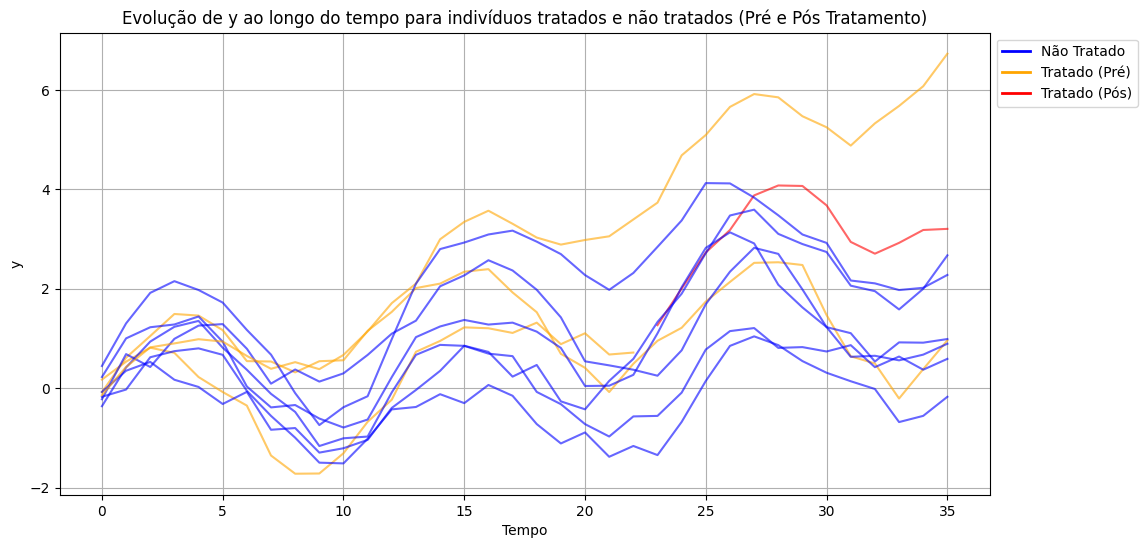

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Definir cores para tratamento e período
treatment_colors = {
    (0, 'any'): "blue",  # Não tratado - mesma cor para todo o período
    (1, 'pre'): "orange",  # Tratado - pré
    (1, 'post'): "red"  # Tratado - pós
}

# Criar a coluna 'treatment_start' para detectar o início do tratamento para cada indivíduo
homogeneo['treatment_start'] = homogeneo.groupby('id')['treatment'].transform(lambda x: (x == 1).idxmax() if x.max() == 1 else np.nan)

# Criar uma coluna para diferenciar pré e pós-tratamento
homogeneo['pre_post'] = homogeneo.apply(lambda row: 'pre' if row['time'] < row['treatment_start'] else 'post', axis=1)

# Gerar o gráfico com a correção na legenda
plt.figure(figsize=(12, 6))

# Criar o gráfico de linhas para cada indivíduo, diferenciando por tratamento e período
for i in range(n_units):
    subset = homogeneo[homogeneo['id'] == i]
    
    # Verificar se o indivíduo foi tratado
    treated = int(subset['treatment'].max())
    
    if treated == 0:
        # Se não recebeu tratamento, usar a mesma cor para todo o período
        sns.lineplot(x='time', y='y', data=subset, color=treatment_colors[(0, 'any')], alpha=0.6)
    else:
        # Se foi tratado, plotar o período pré e pós com cores diferentes
        for period in ['pre', 'post']:
            subset_period = subset[subset['pre_post'] == period]
            color = treatment_colors[(1, period)]
            sns.lineplot(x='time', y='y', data=subset_period, color=color, alpha=0.6)

# Ajustar a legenda para mostrar a relação de cores e tratamento/período
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Não Tratado'),
    Line2D([0], [0], color='orange', lw=2, label='Tratado (Pré)'),
    Line2D([0], [0], color='red', lw=2, label='Tratado (Pós)')
]

plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Evolução de y ao longo do tempo para indivíduos tratados e não tratados (Pré e Pós Tratamento)')
plt.xlabel('Tempo')
plt.ylabel('y')
plt.grid(True)
plt.show()


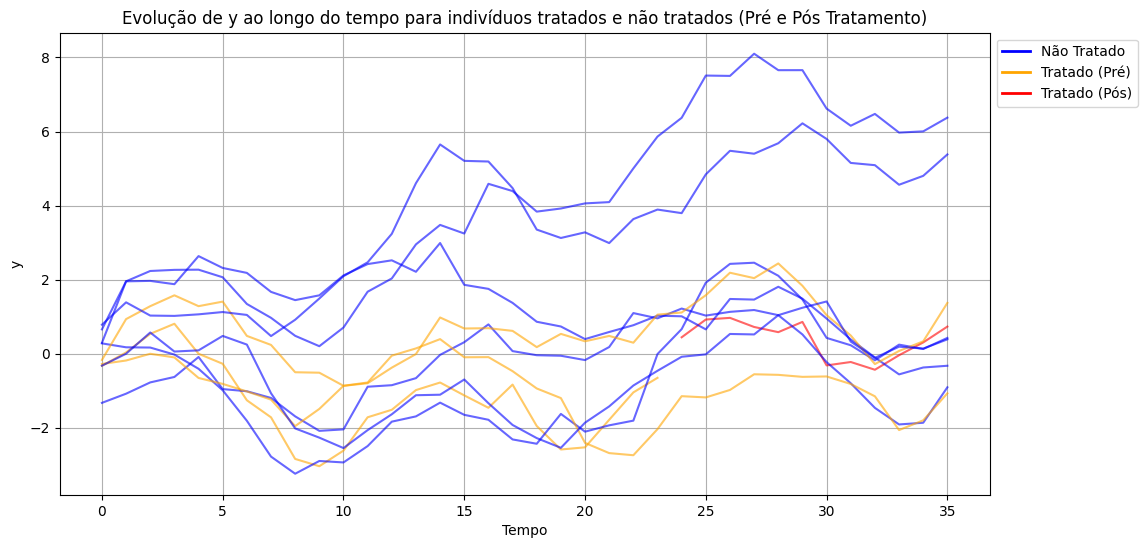

In [252]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Definir cores para tratamento e período
treatment_colors = {
    (0, 'any'): "blue",  # Não tratado - mesma cor para todo o período
    (1, 'pre'): "orange",  # Tratado - pré
    (1, 'post'): "red"  # Tratado - pós
}

# Criar a coluna 'treatment_start' para detectar o início do tratamento para cada indivíduo
hetero['treatment_start'] = hetero.groupby('id')['treatment'].transform(lambda x: (x == 1).idxmax() if x.max() == 1 else np.nan)

# Criar uma coluna para diferenciar pré e pós-tratamento
hetero['pre_post'] = hetero.apply(lambda row: 'pre' if row['time'] < row['treatment_start'] else 'post', axis=1)

# Gerar o gráfico com a correção na legenda
plt.figure(figsize=(12, 6))

# Criar o gráfico de linhas para cada indivíduo, diferenciando por tratamento e período
for i in range(n_units):
    subset = hetero[hetero['id'] == i]
    
    # Verificar se o indivíduo foi tratado
    treated = int(subset['treatment'].max())
    
    if treated == 0:
        # Se não recebeu tratamento, usar a mesma cor para todo o período
        sns.lineplot(x='time', y='y', data=subset, color=treatment_colors[(0, 'any')], alpha=0.6)
    else:
        # Se foi tratado, plotar o período pré e pós com cores diferentes
        for period in ['pre', 'post']:
            subset_period = subset[subset['pre_post'] == period]
            color = treatment_colors[(1, period)]
            sns.lineplot(x='time', y='y', data=subset_period, color=color, alpha=0.6)

# Ajustar a legenda para mostrar a relação de cores e tratamento/período
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Não Tratado'),
    Line2D([0], [0], color='orange', lw=2, label='Tratado (Pré)'),
    Line2D([0], [0], color='red', lw=2, label='Tratado (Pós)')
]

plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Evolução de y ao longo do tempo para indivíduos tratados e não tratados (Pré e Pós Tratamento)')
plt.xlabel('Tempo')
plt.ylabel('y')
plt.grid(True)
plt.show()


In [255]:
# Verificação da distribuição do tratamento ao longo do tempo
def inspect_treatment_distribution(data, treat_col, time_col):
    """
    Inspeciona a distribuição do tratamento ao longo do tempo.

    Args:
    - data: DataFrame com os dados.
    - treat_col: Nome da coluna de tratamento.
    - time_col: Nome da coluna de tempo.

    Returns:
    - Exibe a contagem de tratamento ao longo do tempo.
    """
    treatment_distribution = data.groupby(time_col)[treat_col].sum()
    print("Distribuição do tratamento ao longo do tempo:")
    print(treatment_distribution)
    
# Executar a inspeção nos dados hetero e homogeneo
inspect_treatment_distribution(hetero, treat_col='treatment', time_col='time')
inspect_treatment_distribution(homogeneo, treat_col='treatment', time_col='time')


Distribuição do tratamento ao longo do tempo:
time
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    2.0
19    2.0
20    2.0
21    2.0
22    2.0
23    2.0
24    3.0
25    3.0
26    3.0
27    3.0
28    3.0
29    3.0
30    3.0
31    3.0
32    3.0
33    3.0
34    3.0
35    3.0
Name: treatment, dtype: float64
Distribuição do tratamento ao longo do tempo:
time
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    1.0
21    1.0
22    2.0
23    3.0
24    3.0
25    3.0
26    3.0
27    3.0
28    3.0
29    3.0
30    3.0
31    3.0
32    3.0
33    3.0
34    3.0
35    3.0
Name: treatment, dtype: float64


In [256]:
# Verificar o número de observações pós-tratamento
def inspect_post_treatment_data(data, treat_col, time_col, id_col):
    """
    Verifica o número de observações pós-tratamento.

    Args:
    - data: DataFrame com os dados.
    - treat_col: Nome da coluna de tratamento.
    - time_col: Nome da coluna de tempo.
    - id_col: Nome da coluna de identificação das unidades.

    Returns:
    - Exibe o número de observações pós-tratamento por unidade.
    """
    # Detectar o momento do primeiro tratamento para cada unidade
    data['treatment_start'] = data.groupby(id_col)[treat_col].transform(lambda x: (x == 1).idxmax() if x.max() == 1 else np.nan)
    
    # Calcular o horizonte de tempo após o tratamento
    data['horizon'] = data[time_col] - data['treatment_start']
    
    # Contar observações pós-tratamento por unidade
    post_treatment_count = data[data['horizon'] >= 0].groupby(id_col)['horizon'].count()
    print("Número de observações pós-tratamento por unidade:")
    print(post_treatment_count)
    
# Executar a inspeção nos dados hetero e homogeneo
inspect_post_treatment_data(hetero, treat_col='treatment', time_col='time', id_col='id')
inspect_post_treatment_data(homogeneo, treat_col='treatment', time_col='time', id_col='id')


Número de observações pós-tratamento por unidade:
id
0    12
Name: horizon, dtype: int64
Número de observações pós-tratamento por unidade:
id
0    13
Name: horizon, dtype: int64


In [257]:
# Verificar o início do tratamento para cada unidade
def inspect_treatment_start(data, treat_col, id_col):
    """
    Inspeciona o início do tratamento para cada unidade.

    Args:
    - data: DataFrame com os dados.
    - treat_col: Nome da coluna de tratamento.
    - id_col: Nome da coluna de identificação das unidades.

    Returns:
    - Exibe o início do tratamento por unidade.
    """
    data['treatment_start'] = data.groupby(id_col)[treat_col].transform(lambda x: (x == 1).idxmax() if x.max() == 1 else np.nan)
    treatment_starts = data[['id', 'treatment_start']].drop_duplicates().sort_values(by='treatment_start')
    print("Início do tratamento por unidade:")
    print(treatment_starts)
    
# Executar a inspeção nos dados hetero e homogeneo
inspect_treatment_start(hetero, treat_col='treatment', id_col='id')
inspect_treatment_start(homogeneo, treat_col='treatment', id_col='id')


Início do tratamento por unidade:
     id  treatment_start
0     0             24.0
144   4            162.0
180   5            198.0
36    1              NaN
72    2              NaN
108   3              NaN
216   6              NaN
252   7              NaN
288   8              NaN
Início do tratamento por unidade:
     id  treatment_start
0     0             23.0
36    1             56.0
252   7            274.0
72    2              NaN
108   3              NaN
144   4              NaN
180   5              NaN
216   6              NaN
288   8              NaN


In [261]:
# Verificar a lógica do horizonte pós-tratamento
def inspect_horizon_logic(data, time_col, id_col, treat_col):
    """
    Verifica a lógica do cálculo de horizonte pós-tratamento.

    Args:
    - data: DataFrame com os dados.
    - time_col: Nome da coluna de tempo.
    - id_col: Nome da coluna de identificação das unidades.
    - treat_col: Nome da coluna de tratamento.

    Returns:
    - Exibe a lógica do horizonte pós-tratamento.
    """
    # Detectar o momento do primeiro tratamento
    data['treatment_start'] = data.groupby(id_col)[treat_col].transform(lambda x: (x == 1).idxmax() if x.max() == 1 else np.nan)
    
    # Calcular o horizonte de tempo após o tratamento
    data['horizon'] = data[time_col] - data['treatment_start']
    
    # Exibir uma amostra das unidades com seus horizontes
    print(data[['id', 'time', 'treatment', 'treatment_start', 'horizon']].head(20))
    
# Executar a inspeção nos dados hetero e homogeneo
inspect_horizon_logic(hetero, time_col='time', id_col='id', treat_col='treatment')
inspect_horizon_logic(homogeneo, time_col='time', id_col='id', treat_col='treatment')


    id  time  treatment  treatment_start  horizon
0    0     0        0.0             24.0    -24.0
1    0     1        0.0             24.0    -23.0
2    0     2        0.0             24.0    -22.0
3    0     3        0.0             24.0    -21.0
4    0     4        0.0             24.0    -20.0
5    0     5        0.0             24.0    -19.0
6    0     6        0.0             24.0    -18.0
7    0     7        0.0             24.0    -17.0
8    0     8        0.0             24.0    -16.0
9    0     9        0.0             24.0    -15.0
10   0    10        0.0             24.0    -14.0
11   0    11        0.0             24.0    -13.0
12   0    12        0.0             24.0    -12.0
13   0    13        0.0             24.0    -11.0
14   0    14        0.0             24.0    -10.0
15   0    15        0.0             24.0     -9.0
16   0    16        0.0             24.0     -8.0
17   0    17        0.0             24.0     -7.0
18   0    18        0.0             24.0     -6.0
